# ShapeNet PointCloud Visualization
- By running this script, you can get images of pointclouds.
## To run this code...
- You should prepare the summary file by running sample_and_summarize.py with a trained checkpoint.
- You should install below libraries.
    - matplotlib
    - open3d
    - numpy
    - torch
    - torchvision
    - tqdm

In [1]:
import os
import random
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import open3d as o3d

import numpy as np
import torch
from torchvision.utils import save_image

from draw import draw, draw_pointcloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Set directories
1. experiment_name: log_name.lstrip('gen/') in scripts
2. save_dir: path to save images

In [2]:
save_dir = 'images_attn'
experiment_name = 'shapenet15k-airplane/n_samples_500/'
summary_name = os.path.join('/data/rna_rep_learning/nmsingh/scSet_ckpts/sample_complexity/', experiment_name, 'summary.pth')
summary_train_name = os.path.join('/data/rna_rep_learning/nmsingh/scSet_ckpts/sample_complexity/', experiment_name, 'summary_train_recon.pth')

imgdir = os.path.join(save_dir, experiment_name)
imgdir_gt = os.path.join(imgdir, 'gt')
imgdir_recon = os.path.join(imgdir, 'recon')
imgdir_gen = os.path.join(imgdir, 'gen')
imgdir_gt_train = os.path.join(imgdir, 'gt_train')

os.makedirs(save_dir, exist_ok=True)
os.makedirs(imgdir_gt, exist_ok=True)
os.makedirs(imgdir_recon, exist_ok=True)
os.makedirs(imgdir_gen, exist_ok=True)
os.makedirs(imgdir_gt_train, exist_ok=True)

In [3]:
summary = torch.load(summary_name)
for k, v in summary.items():
    try:
        print(f"{k}: {v.shape}")
    except AttributeError:
        print(f"{k}: {len(v)}")

smp_set: torch.Size([405, 2500, 3])
smp_mask: torch.Size([405, 2500])
smp_att: 7
priors: 8
recon_set: torch.Size([405, 2500, 3])
recon_mask: torch.Size([405, 2500])
posteriors: 8
dec_att: 7
enc_att: 7
enc_hiddens: 13
gt_set: torch.Size([405, 2048, 3])
gt_mask: torch.Size([405, 2048])
mean: torch.Size([405, 1, 3])
std: torch.Size([405, 1, 1])
sid: 13
mid: 13
pid: 13
cardinality: 13


In [4]:
# train
summary_train = torch.load(summary_train_name)
for k, v in summary_train.items():
    try:
        print(f"{k}: {v.shape}")
    except AttributeError:
        print(f"{k}: {len(v)}")
len_att_train = len(summary_train['dec_att'])

recon_set: torch.Size([2832, 2500, 3])
recon_mask: torch.Size([2832, 2500])
posteriors: 8
dec_att: 7
enc_att: 7
enc_hiddens: 89
gt_set: torch.Size([2832, 2048, 3])
gt_mask: torch.Size([2832, 2048])
mean: torch.Size([2832, 1, 3])
std: torch.Size([2832, 1, 1])
sid: 89
mid: 89
pid: 89
cardinality: 89


## Select the samples to visualize
- parse the samples by index.
- below default code will visualize all samples. **Warning: Requires Huge Memory**

In [5]:
#n_viz=10
gen_targets=list(range(len(summary['smp_mask'])))#[:n_viz]
recon_targets=list(range(len(summary['gt_mask'])))#[:n_viz]

gen = summary['smp_set'][gen_targets]
if 'smp_mask' in summary.keys():
    gen_mask = summary['smp_mask'][gen_targets]
else:
    gen_mask = torch.zeros_like(gen)[:,:,0].bool()
gt = summary['gt_set'][recon_targets]
gt_mask = summary['gt_mask'][recon_targets]
recon = summary['recon_set'][recon_targets]
recon_mask = summary['recon_mask'][recon_targets]

In [7]:
recon_targets_train = list(range(len(summary_train['gt_mask'])))#[:n_viz]

gt_train = summary_train['gt_set'][recon_targets_train]
gt_mask_train = summary_train['gt_mask'][recon_targets_train]
enc_att_train = [summary_train['enc_att'][l][:, :, recon_targets_train] for l in range(len_att_train)]

## Visualize

In [8]:
def visualize(gt, gt_mask):
    return draw_pointcloud(gt, gt_mask)

### Visualize Recon

In [ ]:
recon_imgs = visualize(recon, recon_mask)
for idx in range(len(recon_targets)):
    data_idx = recon_targets[idx]
    if torch.nonzero(recon_imgs[idx].float().mean(0) != 1).shape[0] == 0:
        print("SKIP")
        continue
    pos_min = torch.nonzero(recon_imgs[idx].float().mean(0) != 1).min(0)[0]
    pos_max = torch.nonzero(recon_imgs[idx].float().mean(0) != 1).max(0)[0]
    recon_img = recon_imgs[idx][:, pos_min[0]:pos_max[0]+1, pos_min[1]:pos_max[1]+1]
    save_image(recon_img.float(), os.path.join(imgdir_recon, f'{data_idx}.png'))
del recon_img

### Visualize GT

In [ ]:
gt_imgs = visualize(gt, gt_mask)
for idx in range(len(recon_targets)):
    data_idx = recon_targets[idx]
    if torch.nonzero(gt_imgs[idx].mean(0) != 1).shape[0] == 0:
        print("SKIP")
        continue
    pos_min = torch.nonzero(gt_imgs[idx].mean(0) != 1).min(0)[0]
    pos_max = torch.nonzero(gt_imgs[idx].mean(0) != 1).max(0)[0]
    gt_img = gt_imgs[idx][:, pos_min[0]:pos_max[0]+1, pos_min[1]:pos_max[1]+1]
    save_image(gt_img, os.path.join(imgdir_gt, f'{data_idx}.png'))
del gt_imgs
print("DONE")

### Visualize Generated Samples

In [ ]:
gen_imgs = visualize(gen, gen_mask)
for idx in range(len(gen_targets)):
    if torch.nonzero(gen_imgs[idx].mean(0) != 1).shape[0] == 0:
        print("SKIP")
        continue
    data_idx = gen_targets[idx]
    pos_min = torch.nonzero(gen_imgs[idx].mean(0) != 1).min(0)[0]
    pos_max = torch.nonzero(gen_imgs[idx].mean(0) != 1).max(0)[0]
    gen_img = gen_imgs[idx][:, pos_min[0]:pos_max[0]+1, pos_min[1]:pos_max[1]+1]
    save_image(gen_img.float(), os.path.join(imgdir_gen, f'{data_idx}.png'))
del gen_imgs
print("DONE")

### Visualize Train Data

In [ ]:
gt_imgs = visualize(gt_train, gt_mask_train)
for idx in range(len(recon_targets_train)):
    data_idx = recon_targets_train[idx]
    if torch.nonzero(gt_imgs[idx].mean(0) != 1).shape[0] == 0:
        print("SKIP")
        continue
    pos_min = torch.nonzero(gt_imgs[idx].mean(0) != 1).min(0)[0]
    pos_max = torch.nonzero(gt_imgs[idx].mean(0) != 1).max(0)[0]
    gt_img = gt_imgs[idx][:, pos_min[0]:pos_max[0]+1, pos_min[1]:pos_max[1]+1]
    save_image(gt_img, os.path.join(imgdir_gt_train, f'{data_idx}.png'))
del gt_imgs
print('DONE')

### Visualize the latents per person

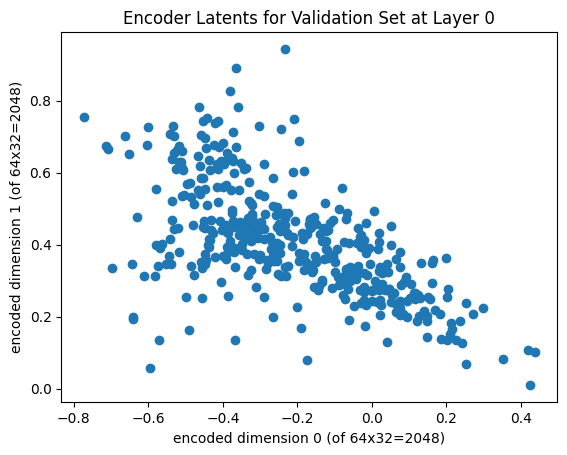

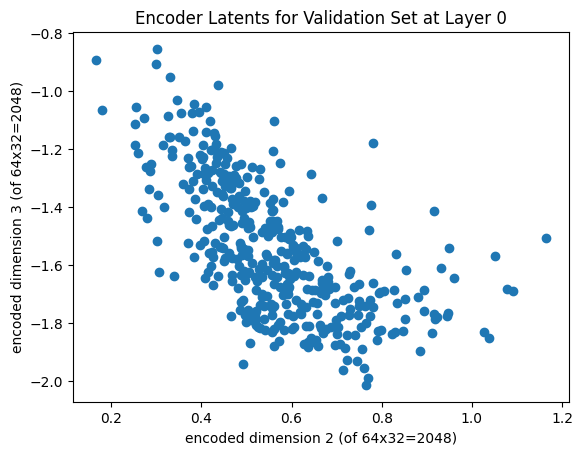

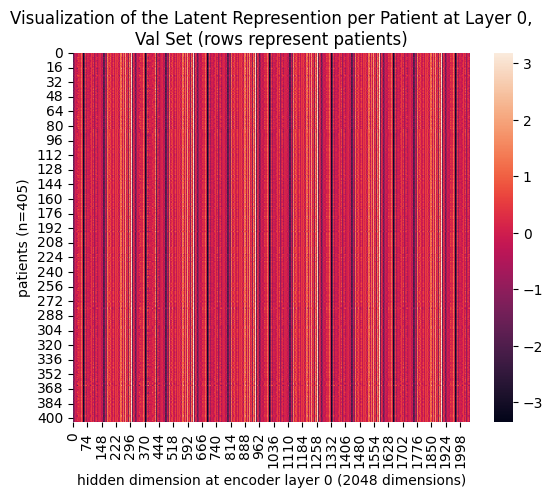

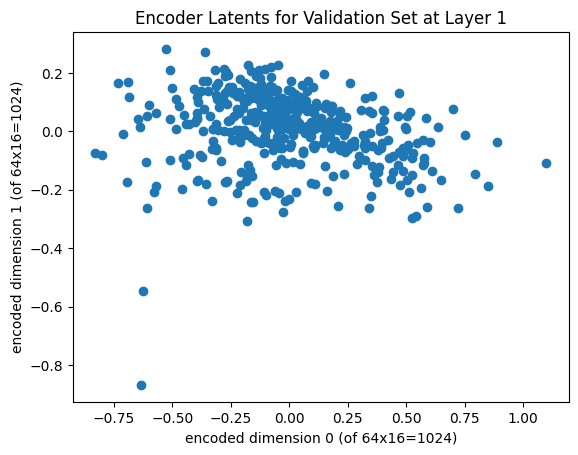

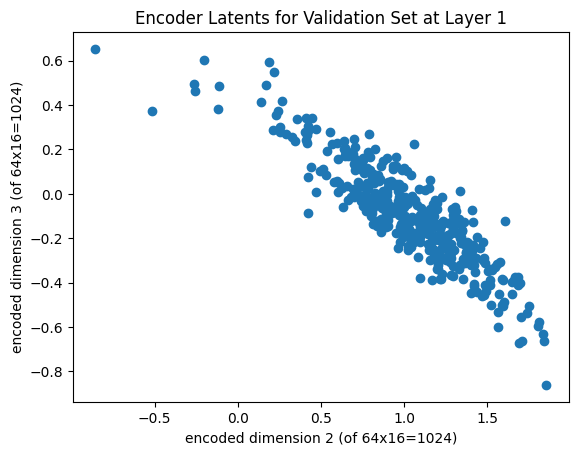

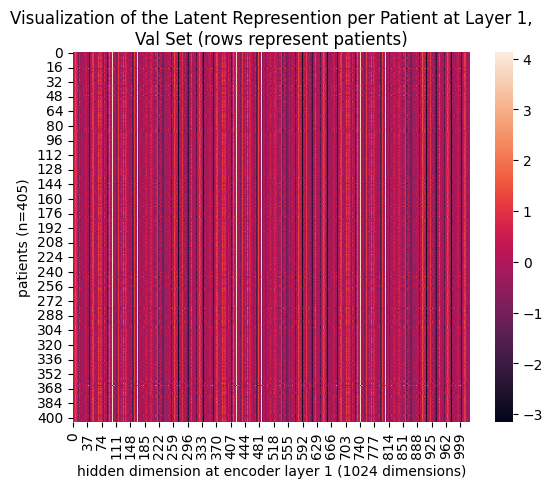

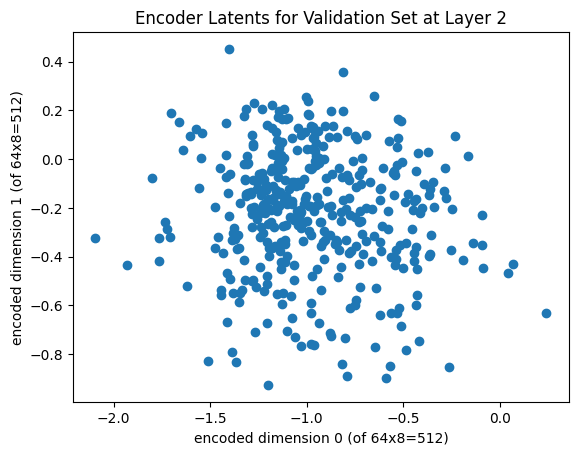

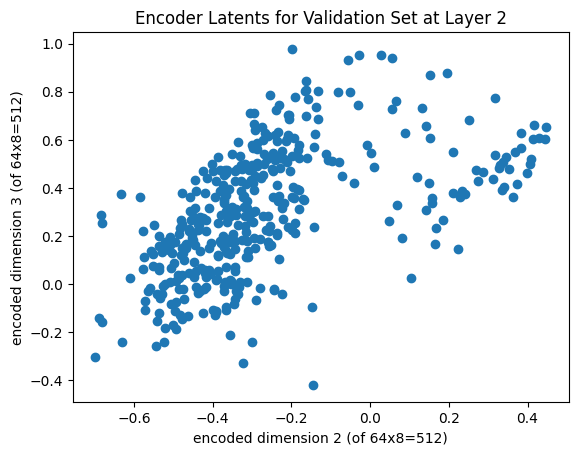

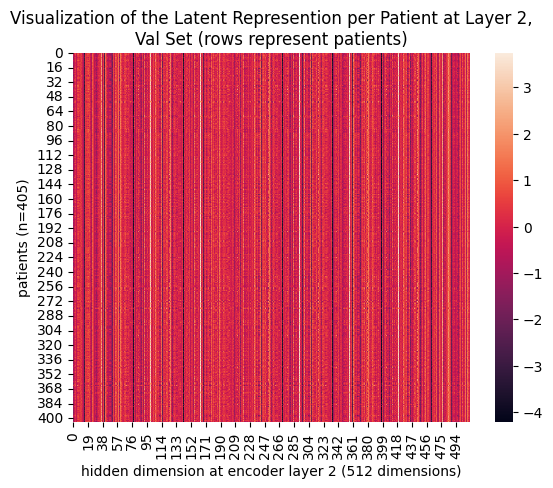

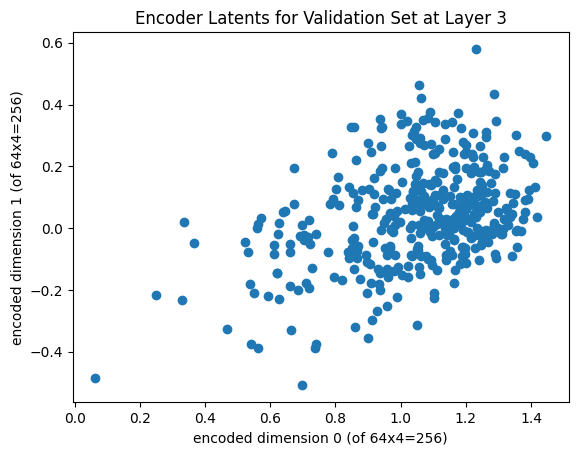

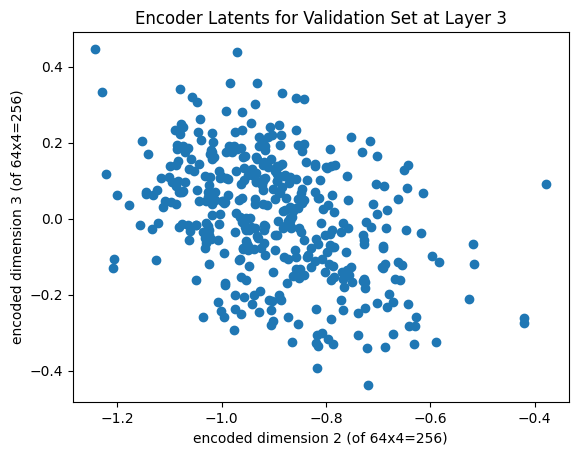

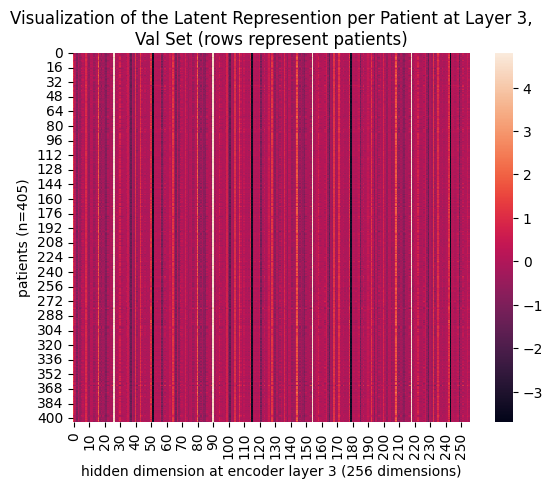

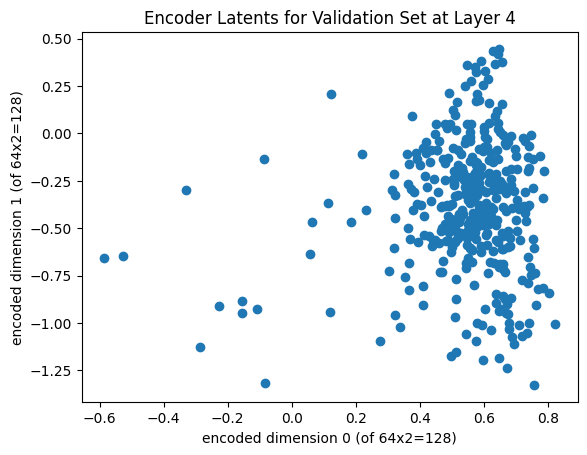

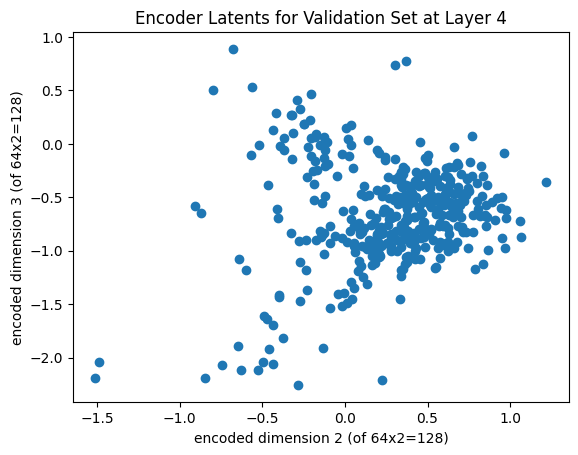

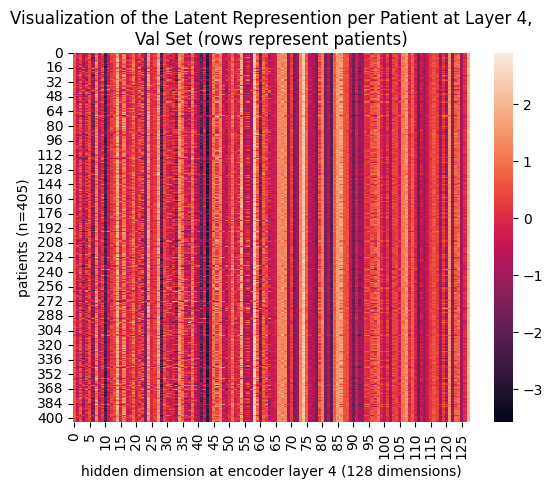

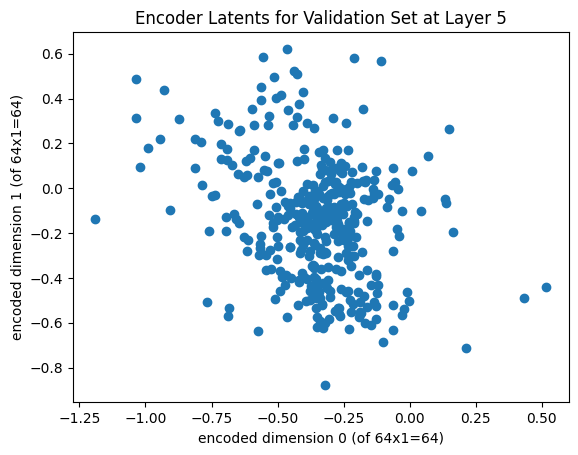

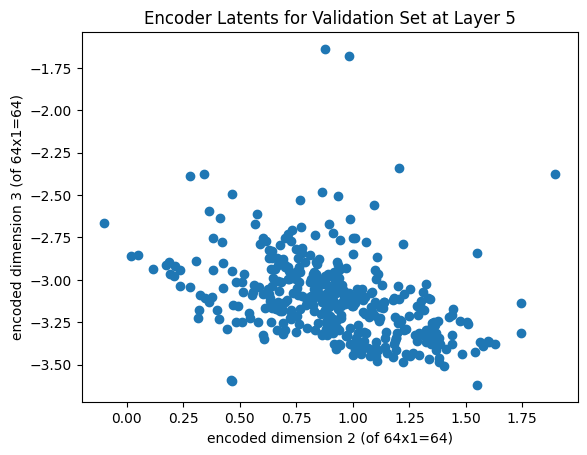

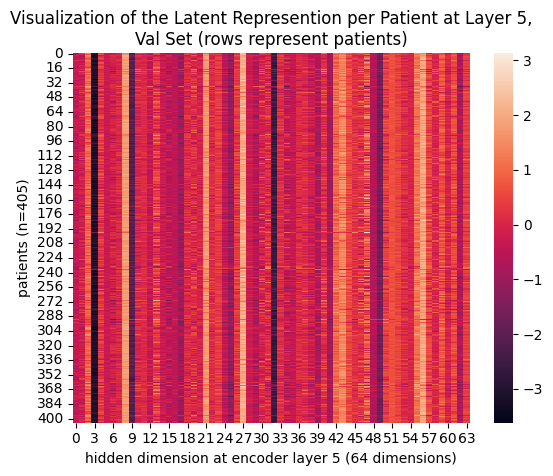

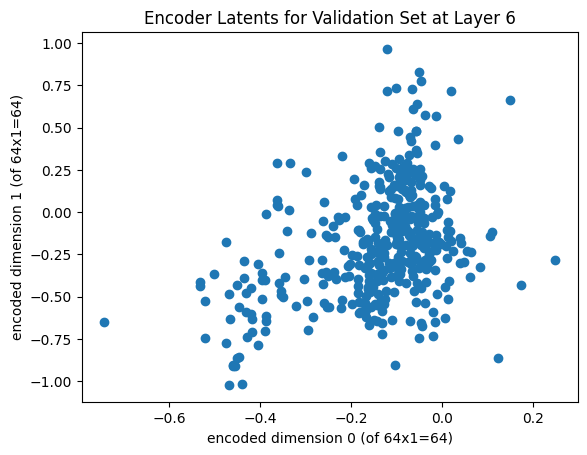

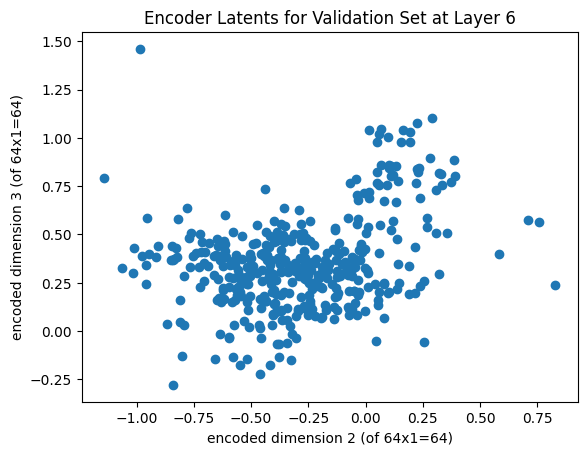

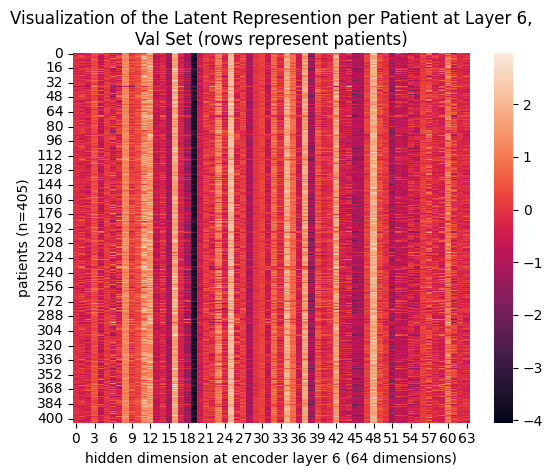

In [19]:
for layer in np.arange(len(summary['enc_hiddens'][0])):
    val_hiddens = torch.concat([batch[layer] for batch in summary['enc_hiddens']]) #final hidden rep in encoder for each patient in the val set
    val_hiddens = val_hiddens.reshape(val_hiddens.shape[0], -1)

    plt.scatter(val_hiddens[:,0],val_hiddens[:,1])
    plt.title("Encoder Latents for Validation Set at Layer {}".format(layer))
    plt.xlabel("encoded dimension 0 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.ylabel("encoded dimension 1 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.show()
    
    plt.scatter(val_hiddens[:,2],val_hiddens[:,3])
    plt.title("Encoder Latents for Validation Set at Layer {}".format(layer))
    plt.xlabel("encoded dimension 2 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.ylabel("encoded dimension 3 (of 64x{}={})".format(summary['enc_hiddens'][0][layer].shape[1], summary['enc_hiddens'][0][layer].shape[1]*64))
    plt.show()
    
    # visualize the dataset in heatmap
    sns.heatmap(val_hiddens)
    plt.title("Visualization of the Latent Represention per Patient at Layer {},\nVal Set (rows represent patients)".format(layer))
    plt.ylabel("patients (n={})".format(len(val_hiddens)))
    plt.xlabel("hidden dimension at encoder layer {} ({} dimensions)".format(layer, val_hiddens.shape[1]))
    plt.show()

In [9]:
val_hiddens = torch.concat([batch[-1] for batch in summary['enc_hiddens']]) #final hidden rep in encoder for each patient in the val set

In [10]:
val_hiddens = val_hiddens.reshape(val_hiddens.shape[0], -1)

In [17]:
val_hiddens.shape

torch.Size([405, 64])

Text(0, 0.5, 'encoded dimension 1 (of 64x2=128)')

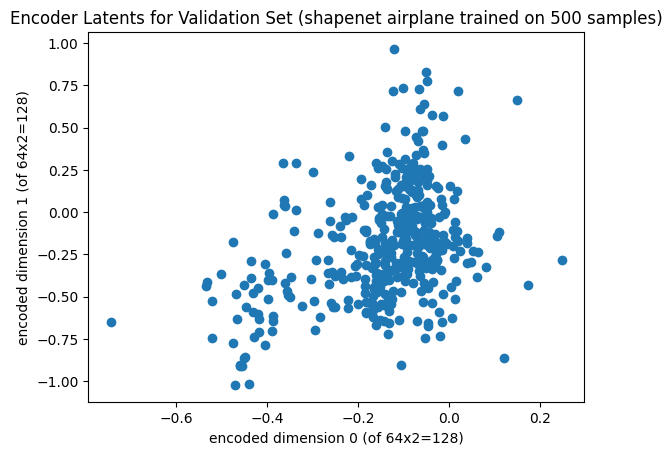

In [16]:
plt.scatter(val_hiddens[:,0],val_hiddens[:,1])
plt.title("Encoder Latents for Validation Set (shapenet airplane trained on 500 samples)")
plt.xlabel("encoded dimension 0 (of 64x2=128)")
plt.ylabel("encoded dimension 1 (of 64x2=128)")
#plt.xlim(-1,1)
#plt.ylim(-1,1)

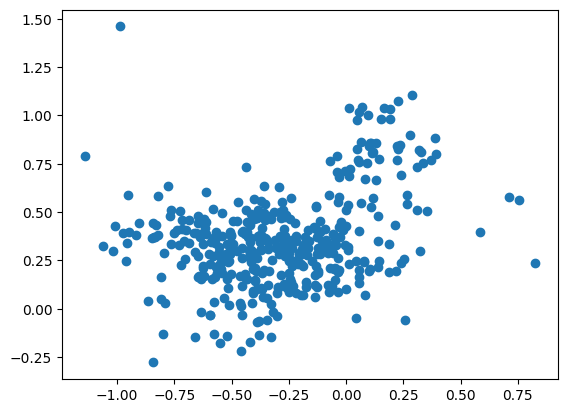

In [13]:
plt.scatter(val_hiddens[:,2],val_hiddens[:,3])
#plt.xlim(-1,1)
#plt.ylim(-1,1)

Text(0.5, 23.52222222222222, 'hidden dimension at final encoder layer (128 dimensions)')

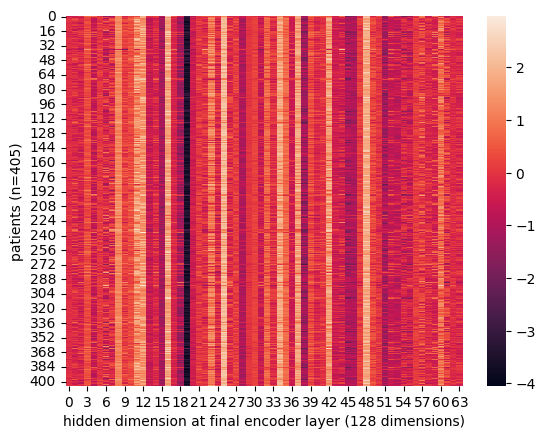

In [14]:
# visualize the dataset in heatmap
sns.heatmap(val_hiddens)
plt.ylabel("patients (n={})".format(len(val_hiddens)))
plt.xlabel("hidden dimension at final encoder layer (128 dimensions)")